In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [15]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem

## params

In [4]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
model_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'

In [5]:
config=Config()

In [6]:
config.D_MODEL=512
config.N_LAYERS=5

## open janssen data

In [7]:
loader_saver = LoaderSaver(
        block_size=100,
        pickle_nist_path='',
        pickle_gnps_path='',
        pickle_janssen_path=output_janssen_file,
    )

In [8]:
all_spectrums_janssen = loader_saver.get_all_spectrums(
            janssen_path,
            100000000,
            use_tqdm=True,
            use_nist=False,
            config=config,
            use_janssen=True,
        )

  0%|                                                                                                                                                                 | 2033/100000000 [00:01<22:30:43, 1233.87it/s]


We reached the end of the array at index 2033


## open ref data

In [9]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [10]:
all_spectrums_reference= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original


In [11]:
all_spectrums_reference[0].params

{'pepmass': (545.0, None),
 'charge': [0],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-Ion Trap',
 'filename': '20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'GNPS-LIBRARY',
 'name': 'Scytonemin M+H',
 'pi': 'Gerwick',
 'datacollector': 'Amanda',
 'smiles': 'OC1=CC=C(\\C=C2\\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\\C(=C/C4=CC=C(O)C=C4)C3=O)=C3C4=C(C=CC=C4)N=C23)C=C1',
 'inchi': 'InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17-25-33-29(23-5-1-3-7-27(23)37-33)31(35(25)41)32-30-24-6-2-4-8-28(24)38-34(30)26(36(32)42)18-20-11-15-22(40)16-12-20/h1-18,39-40H/b25-17+,26-18+',
 'inchiaux': 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 'pubmed': 'N/A',
 'submituser': 'mwang87',
 'libraryquality': '1',
 'spectrumid': 'CCMSLIB00000001550',
 'scans': '1'}

In [12]:
all_spectrums_gnps = [s for s in all_spectrums_reference if s.params['spectrumid'].startswith('CCMS')]

In [13]:
all_spectrums_nist=[s for s in all_spectrums_reference if not(s.params['spectrumid'].startswith('CCMS'))]

## Find those instances that are IN reference

In [16]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [17]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_in_ref]

In [53]:
filtered_canon_smiles_janssen= [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]

In [101]:
ref_indexes_mapped = [[i for i,t in enumerate(canon_smiles_reference) if t==s ]  for s in (filtered_canon_smiles_janssen)]

In [102]:
ref_indexes_mapped

[[222194,
  222195,
  222196,
  222197,
  222198,
  222199,
  222200,
  222201,
  222202,
  222203,
  222204,
  222205],
 [266812],
 [8195],
 [5664,
  5665,
  5666,
  5667,
  5668,
  5669,
  5670,
  5671,
  8015,
  33183,
  33465,
  33598,
  33736,
  34166,
  34437],
 [46230, 46231, 46232, 46233, 46234, 46235, 46236, 46237],
 [33229,
  33528,
  33647,
  33755,
  34007,
  34253,
  34429,
  34694,
  34916,
  34962,
  35023,
  35528,
  45055],
 [21010,
  21205,
  38280,
  39218,
  39284,
  39327,
  39782,
  39865,
  40390,
  40728,
  89041,
  89042,
  89043,
  89044,
  89045,
  89046,
  89047,
  89048,
  89049,
  89050,
  89051,
  89052,
  89053],
 [294189,
  295693,
  295855,
  295866,
  295891,
  295896,
  295969,
  296909,
  296970,
  297076,
  297079,
  297111,
  297177,
  297593,
  297596,
  297678,
  297735,
  297764,
  297783,
  297850,
  297859,
  297881,
  298047,
  298065,
  298076,
  298089,
  298091,
  303612,
  303613,
  303614,
  303615,
  303616,
  303617,
  303618,
  30361

## load encoder

In [18]:
encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS))

Using cosine library from Pytorch?: True


## data loader

In [19]:
dataset_janssen= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen)
dataloader_janssen= DataLoader(dataset_janssen, batch_size=config.BATCH_SIZE,  num_workers=0)


Preprocessing all the data ...


1622it [00:01, 1253.99it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [20]:
dataset_reference= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_reference)
dataloader_reference= DataLoader(dataset_reference, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


326386it [00:04, 73436.68it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [21]:
dataset_nist= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_nist)
dataloader_nist= DataLoader(dataset_nist, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


263745it [00:03, 84076.76it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [22]:
dataset_gnps= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_gnps)
dataloader_gnps= DataLoader(dataset_gnps, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


62641it [00:01, 49033.66it/s]


Finished preprocessing 
loading data
Normalizing intensities


## forward

In [23]:
embeddings_janssen= encoder.get_embeddings(dataloader_janssen)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [24]:
embeddings_reference = encoder.get_embeddings(dataloader_reference)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [25]:
#embeddings_nist = encoder.get_embeddings(dataloader_nist)

In [26]:
#embeddings_gnps = encoder.get_embeddings(dataloader_gnps)

## compute similarities

In [27]:
similarities= CosineSimilarity.batch_cosine_similarity_combinations(embeddings_janssen, embeddings_reference)

In [28]:
similarities.shape

(1622, 326386)

## heat map

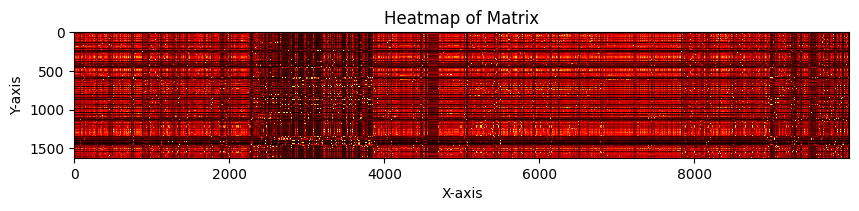

In [29]:
plt.figure(figsize=(10,100))
plt.imshow(similarities[:, 0:10000], cmap='hot', interpolation='nearest')
#plt.colorbar()  # Add colorbar to show scale
plt.title('Heatmap of Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Show PCA

In [30]:
from src.analog_discovery.pca_embeddings import PCAEmbeddings

In [31]:
pca = PCAEmbeddings()

In [32]:
pca.fit(embeddings_reference)

In [33]:
pca_ref= pca.transform(embeddings_reference)

In [34]:
pca_janssen= pca.transform(embeddings_janssen)

In [35]:
#pca_nist= pca.transform(embeddings_nist)

In [36]:
#pca_gnps= pca.transform(embeddings_gnps)

In [37]:
from src.plotting import Plotting

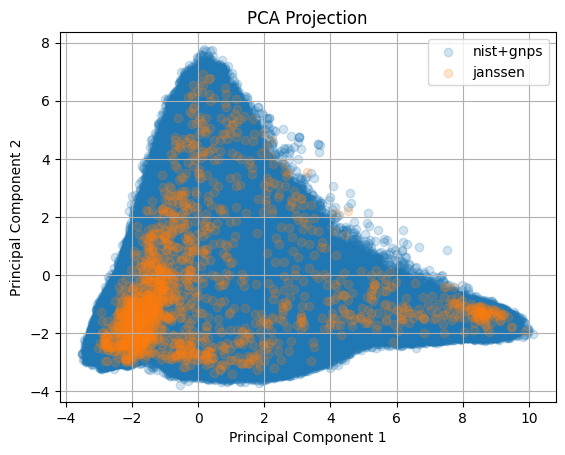

In [38]:
Plotting.plot_n_pca([pca_ref, pca_janssen,], ['nist+gnps','janssen', ], alpha=0.2)

## Based on the similarities find the ranking of the real spectrum

In [39]:
similarities.shape

(1622, 326386)

In [45]:
## get the indexes (argosort) of each row, in descending order
arg_sort_similarities=np.argsort(similarities, axis=1)[:,::-1]

In [72]:
arg_sort_similarities

array([[222198, 222196, 222197, ...,  64399, 191938, 102117],
       [ 16264,  17951,  14942, ...,   9862,  11135,  11654],
       [  8195,  20867,  21047, ..., 242977, 242980, 242982],
       ...,
       [125670, 266050, 262400, ..., 242977, 242979,  49962],
       [ 13114, 264501, 294324, ..., 191938,  50540, 291034],
       [ 13117,  13118,  13116, ..., 242268, 100912, 100911]])

In [58]:
ref_indexes_mapped=np.array(ref_indexes_mapped)

In [74]:
ref_indexes_mapped

array([222194, 266812,   8195, ...,  13086,  13113,  13116])

In [79]:
arg_sort_similarities.shape

(1622, 326386)

In [89]:
ref_indexes_mapped

array([222194, 266812,   8195, ...,  13086,  13113,  13116])

In [106]:
len(ref_indexes_mapped)

1622

In [93]:
##  find the ordered index of the original index in the ref dataset
# Broadcasting to create a boolean mask
#mask = (arg_sort_similarities == ref_indexes_mapped[:, np.newaxis])

# Finding the column indices where the values match
#rankings = np.where(mask)[1]

In [114]:
rankings = np.zeros(arg_sort_similarities.shape[0])
for index,row_ref in tqdm(enumerate(arg_sort_similarities)):
    rankings[index] = min([np.where(row_ref==i)[0] for i in ref_indexes_mapped[index]])

1622it [00:03, 475.95it/s]


In [115]:
rankings

array([   0., 1580.,    0., ...,   10.,    0.,    0.])

In [116]:
## you will get a ranking in each row. You can then plot the histogram, and the average ranking obtained
#_=plt.hist(rankings, bins=50)

In [117]:
np.median(rankings)

1.0

In [157]:
np.mean(rankings)

1815.374229346486

In [118]:
rankings[0:10]

array([0.00e+00, 1.58e+03, 0.00e+00, 2.00e+00, 1.36e+02, 0.00e+00,
       0.00e+00, 1.00e+00, 2.00e+00, 0.00e+00])

Text(0, 0.5, 'Freq')

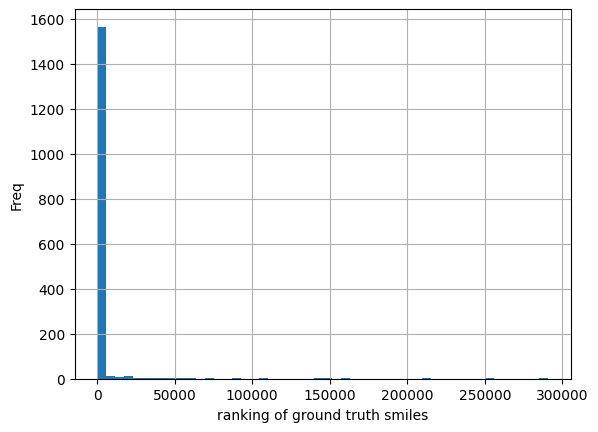

In [155]:
_=plt.hist(rankings, bins=50)
plt.grid()
plt.xlabel('ranking of ground truth smiles')
plt.ylabel('Freq')
#plt.yscale('log')

In [188]:
rankings_x = np.arange(0,400)

In [189]:
rankings[rankings<1].shape[0]/rankings.shape[0]

0.47410604192355116

In [190]:
rankings_proportion = [rankings[rankings<=r].shape[0]/rankings.shape[0] for r in rankings_x]

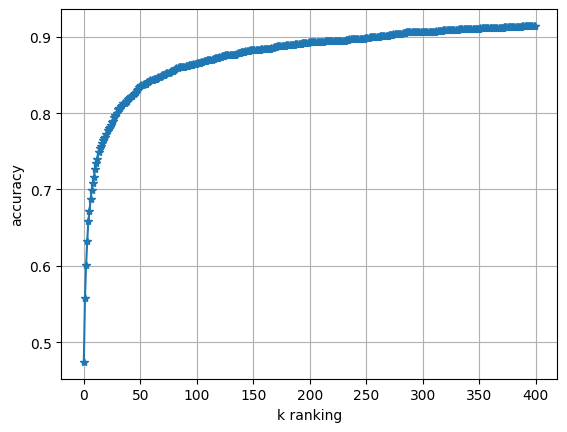

In [191]:
plt.plot(rankings_x, rankings_proportion, marker='*')
plt.xlabel('k ranking')
plt.ylabel('accuracy')
#plt.ylim([0,1])
plt.grid()

## Check the tanimoto similarity with the highest prediction

In [125]:
arg_max_sim= np.argmax(similarities, axis=1)

In [126]:
max_sim = np.max(similarities, axis=1)

In [127]:
spectrums_retrieved = [all_spectrums_reference[ind] for ind in arg_max_sim]

In [128]:
smiles_retrieved = [s.smiles for s in spectrums_retrieved]

In [129]:
smiles_janssen = [s.smiles for s in all_spectrums_janssen]

In [130]:
from src.tanimoto import Tanimoto

In [131]:
tanimoto_retrieved = [Tanimoto.compute_tanimoto_from_smiles(s0,s1) for s0, s1 in zip(smiles_janssen, smiles_retrieved)]

Text(0, 0.5, 'frequency')

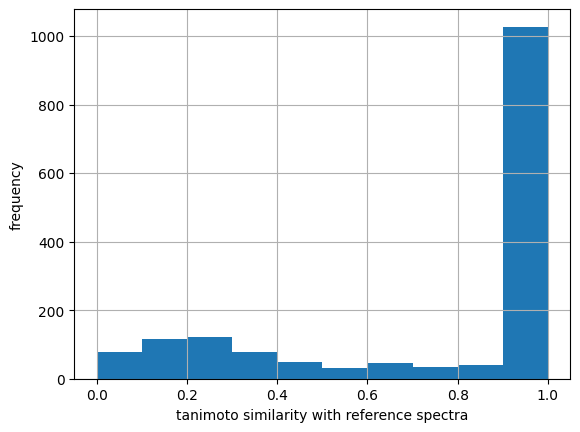

In [132]:
plt.hist(tanimoto_retrieved)
plt.grid()
plt.xlabel('tanimoto similarity with reference spectra')
plt.ylabel('frequency')

In [136]:
tanimoto_retrieved = np.array(tanimoto_retrieved)

In [138]:
tanimoto_retrieved[tanimoto_retrieved>0.7].shape[0]/tanimoto_retrieved.shape[0]

0.6800246609124537

## saving of results

In [193]:
similarity_name='simba'

In [194]:
results = {'rankings_x':rankings_x,
          'rankings_y': rankings_proportion,
           'rankings':rankings}

In [195]:
with open('./notebooks/discovery_search/results/'+similarity_name + '_results_analog_discovery_ranking.pkl', 'wb') as f:
    dill.dump(results, f)